# HGCAL FE studies

### imports and initial setup

In [10]:
#imports and setup
%matplotlib inline
%cd /home/naodell/work/hgcal

from time import sleep
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly as py

from descartes import PolygonPatch
from tqdm import tqdm_notebook

import scripts.helpers as hlp
from skhep.modeling import bayesian_blocks

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 16})

#%connect_info

/home/naodell/work/hgcal


### Convert data from root ntuples to dataframes

In [2]:
infile = open('data/mc_mixtures/qcd_pt15to7000_skim_test/output_0.pkl', 'rb')
#infile = open('data/mc_mixtures/single_electron_pt15_pu200_skim_test/output_0.pkl', 'rb')
threshold = pickle.load(infile)
gen = pickle.load(infile)
data = pickle.load(infile)

features = ['zside', 'layer', 'sector', 'panel', 'cell', 'subdet',
            'x', 'y', 'z', 
            'pt', 'reco_e', 'sim_e']


### Visualizations of detector hits, panels, and occupancies

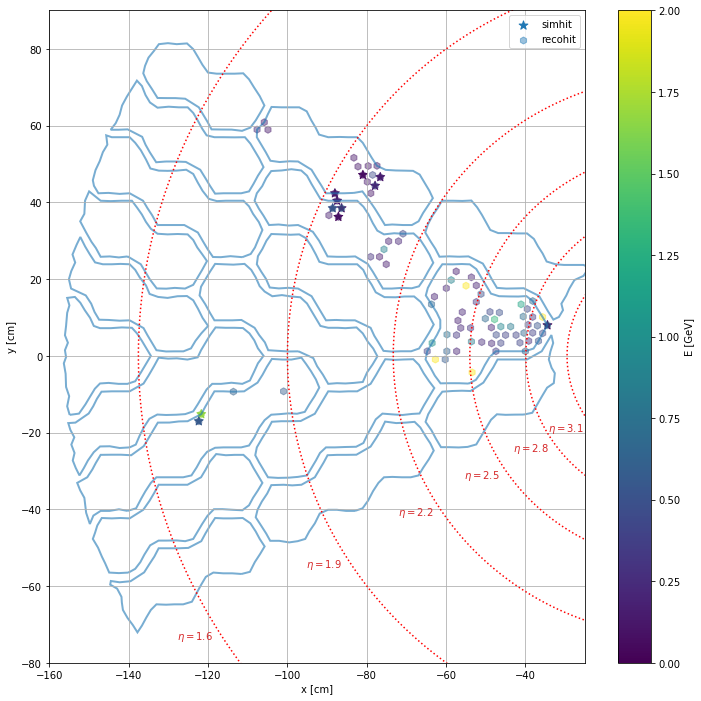

In [3]:
# get patches for module layouts
layer = 7
sector = 1
panel = 4
df = data[8].query('sig_evt')[features]
patch_file = open(f'data/panel_patches_zplus_{layer}.pkl', 'rb')
patches = pickle.load(patch_file)
patch_file.close()

fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='white')
for p, ashape in patches[sector].items():
    col = 'C0'
    patch = PolygonPatch(ashape, fill=False, ec=col, linestyle='-', linewidth=2, label='_nolegend_', alpha=0.6)
    ax.add_patch(patch)

df_skim = df.query(f'subdet == 3 and zside == 1 and sector == 1 and layer == {layer}')
mask = df_skim.sim_e > 0

sim_scat  = ax.scatter(df_skim[mask].x, df_skim[mask].y, c=df_skim.sim_e[mask], 
                       cmap='viridis', 
                       marker='*', 
                       vmin=0.,
                       vmax=2.,
                       s=85, 
                       alpha=1.
                      )
reco_scat = ax.scatter(df_skim.x, df_skim.y, c=df_skim.reco_e, 
                       cmap='viridis', 
                       marker='h', 
                       vmin=0.,
                       vmax=2.,
                       s=50, 
                       alpha=0.45
                      )

ax.set_ylim(-80, 90)
ax.set_xlim(-160, -25)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
#ax.set_facecolor('white')

# draw some concentric circles
eta   = np.arange(1.6, 3.2, 0.3)
theta = 2*np.arctan(np.exp(-eta))
r     = df_skim.iloc[0].z*np.tan(theta) 
phi   = np.linspace(np.pi/2, 3*np.pi/2, 1000)
xcoord, ycoord  = np.outer(r, np.cos(phi)), np.outer(r, np.sin(phi)) 

for i, (x, y) in enumerate(zip(xcoord, ycoord)):
    ax.plot(x, y, 'r:', label='_nolegend_')
    phi_pos = 7*np.pi/6
    ax.text((r[i] + 10)*np.cos(phi_pos), (r[i] + 10)*np.sin(phi_pos), r'$\eta={0:.1f}$'.format(eta[i]), color='C3', fontsize=10)

cbar_reco = plt.colorbar(reco_scat, ax=ax, label='E [GeV]')
cbar_reco.set_alpha(1)
cbar_reco.draw_all()

#cbar_sim = plt.colorbar(sim_scat, ax=ax, label=r'$E_{sim}$')
plt.legend(['simhit', 'recohit'])
plt.grid()

plt.savefig('plots/hits_test.png')
plt.show()

In [43]:
# sample occupancy plot
layer = 7
df = pd.concat(data)
df = df.query('sig_evt == False')
df['count'] = np.ones(df.shape[0])
df_avg = df.groupby(['layer', 'panel']).sum()/(7*2*6*100) # sum_hits/(n_bx*n_sides*n_sectors*n_epochs)
s_panel = df_avg.query(f'layer == {layer}')['count']
s_panel = s_panel.loc[layer]

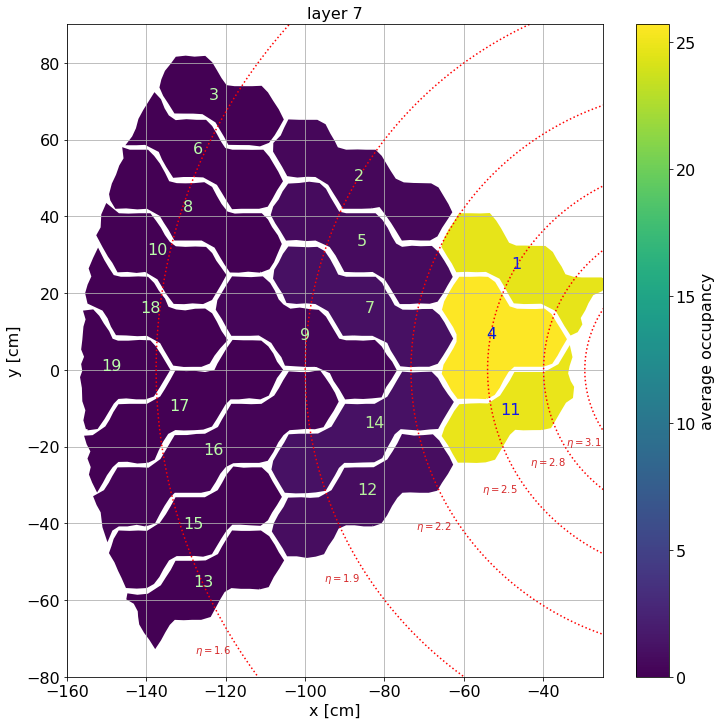

In [44]:
# tmp hack
centers = [( -45.996555,  26.552443), ( -85.601143,  49.418068), (-122.204628,  70.561249),
           ( -52.309528,   8.186293), ( -85.023285,  32.505623), (-126.216042,  56.438793),
           ( -83.052231,  14.980803), (-128.726608,  41.261883), ( -99.199333,   7.929051),
           (-137.761444,  30.080639), ( -48.818104, -11.489166), ( -84.926186, -32.474018),
           (-126.202728, -56.422054), ( -83.127579, -14.974498), (-128.724808, -41.280033),
           (-123.665054, -21.916286), (-132.247528, -10.519128), (-139.554230,  14.877615),
           (-149.350327,  -0.036200)
          ]

def invert_ctuple(ctuple):
    return [1 - c for c in ctuple[:-1]] + [1.]

fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='white')

for p, ashape in patches[sector].items():
    if p not in s_panel.index:
        col = plt.cm.viridis(0)
    else:
        col = plt.cm.viridis(s_panel.loc[p]/s_panel.max())
    patch  = PolygonPatch(ashape, fc=col, fill=True, ec=col, linestyle='-', linewidth=3, label='_nolegend_', alpha=1)
    extent = patch.get_extents().bounds
    ax.add_patch(patch)
    
    c = centers[p-1]
    ax.text(c[0]-2, c[1], f'{p}', color=invert_ctuple(col))
    
ax.set_ylim(-80, 90)
ax.set_xlim(-160, -25)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title(f'layer {layer}')
#ax.set_facecolor('white')

dummy = plt.scatter([0, 0], [0, 0], cmap='viridis', c=[0, s_panel.max()])
cbar = plt.colorbar(dummy, ax=ax, label='average occupancy')
cbar.set_alpha(1)
cbar.draw_all()

# draw some concentric circles
eta   = np.arange(1.6, 3.2, 0.3)
theta = 2*np.arctan(np.exp(-eta))
r     = df_skim.iloc[0].z*np.tan(theta) 
phi   = np.linspace(np.pi/2, 3*np.pi/2, 1000)
xcoord, ycoord  = np.outer(r, np.cos(phi)), np.outer(r, np.sin(phi)) 

for i, (x, y) in enumerate(zip(xcoord, ycoord)):
    ax.plot(x, y, 'r:', label='_nolegend_')
    phi_pos = 7*np.pi/6
    ax.text((r[i] + 10)*np.cos(phi_pos), (r[i] + 10)*np.sin(phi_pos), r'$\eta={0:.1f}$'.format(eta[i]), color='C3', fontsize=10)

plt.grid()
#plt.savefig('plots/panel_numbering_test.png')
plt.savefig('plots/panel_occupancy_test.pdf')
plt.show()

In [119]:
# sample occupancy plot
g = df.groupby(['layer', 'wafer', 'cell']) # sum_hits/(n_bx*n_sides*n_sectors*n_epochs)
df_avg = g.sum()/(7*2*6*100) # sum_hits/(n_bx*n_sides*n_sectors*n_epochs)
s_cell = df_avg.loc[layer]['count']

cell_map = pd.read_pickle('data/cell_map.pkl')
cell_map = cell_map.loc[1, layer]
cell_map#.drop_duplicates()

tc_x        tc_y
tc_wafer tc_cell                        
1        1        244.908936    6.413166
         2        244.237656   19.221920
         3        242.896912   31.977989
         4        240.890457   44.646408
         5        238.223740   57.192451
         6        234.904022   69.581741
         7        230.940460   81.780304
         8        226.343918   93.754723
         9        221.126984  105.472153
         10       215.303940  116.900497
         11       231.024353    6.049586
         12       230.391174   18.132179
         13       229.126465   30.165070
         14       227.233704   42.115280
         15       224.718170   53.950058
         16       221.586685   65.636955
         17       217.847824   77.143951
         18       213.511856   88.439499
         19       208.590698   99.492653
         20       203.097794  110.273102
         21       218.067245    5.710291
         22       217.469528   17.115223
         23       216.275742   28.473240
         24       214.489166   39.753220
         25       212.114685   50.924240
         26       209.158844   61.955673
         27       205.629684   72.817291
         28       201.536926   83.479317
         29       196.891739   93.912544
         30       191.706894  104.088356
...                      ...         ...
465      37      -166.713867   34.572926
         38      -167.838394   32.625149
         39      -168.906723   30.385218
         40      -164.103287   34.642483
         41      -165.308182   32.138206
         42      -166.432724   30.190437
         43      -167.557266   28.242668
         44      -162.834183   32.332981
         45      -164.183640   30.190435
         46      -165.308182   28.242668
         47      -166.463959   26.349003
466      16      -168.619339   42.266609
         17      -169.525208   44.311775
         20      -170.368637   41.877060
         32      -166.151581   55.024509
         33      -167.276123   53.076733
         36      -165.308182   53.563675
         37      -166.432724   51.615906
         38      -167.838394   49.181194
         39      -168.962952   46.259541
         40      -164.183640   51.615906
         41      -165.422714   49.217266
         42      -166.651382   46.944866
         43      -167.900879   45.249584
         44      -163.059082   49.473354
         45      -164.383560   47.482311
         46      -165.645554   44.993496
         47      -166.945023   43.045719
467      44      -162.777954   64.763351
         45      -163.902496   62.815582

[37648 rows x 2 columns]

AttributeError: 'Series' object has no attribute 'x'

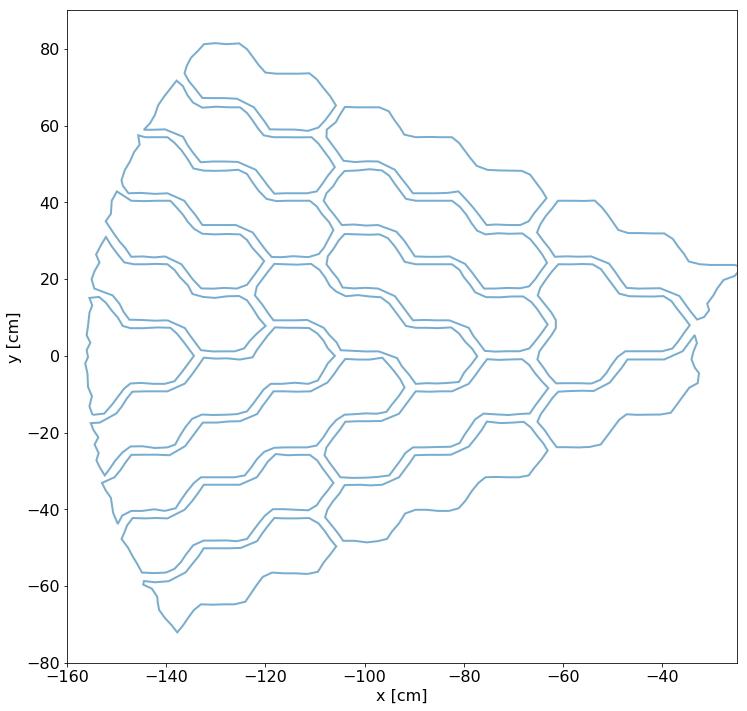

In [51]:
# by cell occupancies

fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='white')

for p, ashape in patches[sector].items():
    patch = PolygonPatch(ashape, fc=col, fill=False, ec='C0', linestyle='-', linewidth=2, label='_nolegend_', alpha=0.6)
    extent = patch.get_extents().bounds
    ax.add_patch(patch)
    
ax.set_ylim(-80, 90)
ax.set_xlim(-160, -25)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
#ax.set_facecolor('white')

scat = ax.scatter(s_cell.x.values, s_cell.y.values, c=s_cell['count'].values,
                  cmap='viridis', 
                  marker='h', 
                  vmin=0.,
                  vmax=2.,
                  s=50, 
                  alpha=0.45
                 )

#dummy = plt.scatter([0, 0], [0, 0], cmap='viridis', c=[0, s_cell.max()])
cbar = plt.colorbar(scat, ax=ax, label='average occupancy')
cbar.set_alpha(1)
cbar.draw_all()

# draw some concentric circles
eta   = np.arange(1.6, 3.2, 0.3)
theta = 2*np.arctan(np.exp(-eta))
r     = df_skim.iloc[0].z*np.tan(theta) 
phi   = np.linspace(np.pi/2, 3*np.pi/2, 1000)
xcoord, ycoord  = np.outer(r, np.cos(phi)), np.outer(r, np.sin(phi)) 

for i, (x, y) in enumerate(zip(xcoord, ycoord)):
    ax.plot(x, y, 'r:', label='_nolegend_')
    phi_pos = 7*np.pi/6
    ax.text((r[i] + 10)*np.cos(phi_pos), (r[i] + 10)*np.sin(phi_pos), r'$\eta={0:.1f}$'.format(eta[i]), color='C3', fontsize=10)

plt.grid()
#plt.savefig('plots/panel_numbering_test.png')
plt.savefig('plots/panel_occupancy_test.pdf')
plt.show()